# Exercise 3B

In this exercise, you will explore how the DBSCAN clustering algorithm identifies dense groups and outliers in the Pokémon statistics dataset. You will analyze the dataset, scale features, determine DBSCAN parameters, run DBSCAN, and interpret the clustering results.

In [25]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [26]:
# Download latest version
path = kagglehub.dataset_download("abcsds/pokemon")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pokemon' dataset.
Path to dataset files: /kaggle/input/pokemon


In [27]:
if os.path.isdir(path):
  print(True)

contents = os.listdir(path)
contents

mydataset = path + "/" + contents[0]
mydataset


df = pd.read_csv(mydataset)

True


## 1. Load the Dataset (8 pts)

Load the Pokémon dataset into a pandas DataFrame.

Show the first five rows (3 pts)

In [28]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False



How many Pokémon are in the dataset? (2 pts)


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [30]:
df.shape[0]

800

- 800 Pokemons in the dataset


List all columns available (3 pts)

In [31]:
df.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

## 2: Select Features & Clean the Data (8 pts)

Select the numeric features needed for clustering (HP, Attack, Defense, Sp. Atk, Sp. Def, Speed). (3 pts)

In [32]:
features = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
data_features = df[features]
data_features.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,45,49,49,65,65,45
1,60,62,63,80,80,60
2,80,82,83,100,100,80
3,80,100,123,122,120,80
4,39,52,43,60,50,65


Are there any missing values? (2 pts)

In [33]:
df.isna().sum()

,0
#,0
Name,0
Type 1,0
Type 2,386
Total,0
HP,0
Attack,0
Defense,0
Sp. Atk,0
Sp. Def,0


If missing values exist, describe how you handled them (3 pts)

In [34]:
# In Pokémon, some species have two types while others have only one.
# Instead of dropping entries with a missing second type, we can fill
# those values with a “None” placeholder. This allows us to retain all
# Pokémon in the dataset while explicitly indicating which ones have
# only a single type.

df["Type 2"] = df["Type 2"].fillna("None")
print(df["Type 2"].value_counts())
df.info()

Type 2
None        386
Flying       97
Ground       35
Poison       34
Psychic      33
Fighting     26
Grass        25
Fairy        23
Steel        22
Dark         20
Dragon       18
Ice          14
Rock         14
Water        14
Ghost        14
Fire         12
Electric      6
Normal        4
Bug           3
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      800 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64

# 3. Scale the Features (10 pts)

Apply StandardScaler to the selected features.

Show the transformed feature sample (e.g., first 5 rows) (10 pts)


In [35]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_features)

scaled_df = pd.DataFrame(scaled_features, columns=data_features.columns)
scaled_df.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503
1,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015
2,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635
3,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635
4,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853


## 4. Determine a Suitable eps Value (10 pts)

Using k = 4:
Compute the distance to the 4th nearest neighbor for each Pokémon (6 pts)

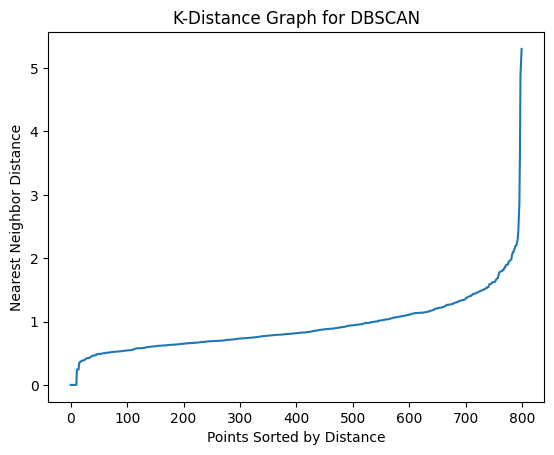

In [36]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_df)
distances, _ = neighbors.kneighbors(scaled_df)

k_distances = np.sort(distances[:, 3])
plt.plot(k_distances)
plt.xlabel('Points Sorted by Distance')
plt.ylabel('Nearest Neighbor Distance')
plt.title('K-Distance Graph for DBSCAN')
plt.show()

In [37]:
y = k_distances
x = np.arange(len(y))
p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])

distances = np.abs(
    np.cross(p2 - p1, p1 - np.vstack((x, y)).T)
) / np.linalg.norm(p2 - p1)

elbow_index = np.argmax(distances)
optimal_eps = y[elbow_index]

print("Optimal eps:", optimal_eps)

if 1.4 <= optimal_eps <= 2.0:
    print("Accepted eps:", optimal_eps)
else:
    print("Fallback to visual range")

Optimal eps: 1.5248638064269173
Accepted eps: 1.5248638064269173


/tmp/ipython-input-1382769040.py:7: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross(p2 - p1, p1 - np.vstack((x, y)).T)


What is your chosen eps based on the "elbow"? (2 pts)

- The optimal eps is 1.5

One-sentence explanation of your reasoning (2 pts)

- An eps value of 1.5 was chosen because it sits at the elbow of the k-distance plot—the point of highest curvature where distances start rising sharply.

## 5. Run DBSCAN (10 points)

Run DBSCAN using your chosen eps and min_samples


How many clusters did DBSCAN find? (4 pts)

In [38]:
min_samples = [4, 6, 8, 10, 12, 15]

for min_sample in min_samples:
    db = DBSCAN(eps=1.5, min_samples=min_sample, metric="euclidean")
    db.fit(scaled_df)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_samples={min_sample}: clusters={n_clusters}")

min_samples=4: clusters=1
min_samples=6: clusters=2
min_samples=8: clusters=1
min_samples=10: clusters=1
min_samples=12: clusters=1
min_samples=15: clusters=1


experimenting with different min_samples, min_samples=6 gives us 2 clusters.

How many Pokémon were labeled as noise? (4 pts)

In [39]:
db = DBSCAN(eps=1.5, min_samples=6, metric="euclidean")
db.fit(scaled_df)
labels = db.labels_
n_noise = list(labels).count(-1)
print(f"noise points={n_noise}")


noise points=44


- 44 noise points.

Show the unique labels output by DBSCAN (2 pts)

In [40]:
print("Unique labels:", np.unique(labels))

Unique labels: [-1  0  1]


## 6. Attach Cluster Labels to the Original Dataset (7 points)

Add the cluster labels back to the original DataFrame (3 pts)

In [41]:
# Add cluster labels to the DataFrame
df['cluster'] = db.labels_

Show the first 10 rows including the cluster label (4 pts)

In [42]:
df.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,cluster
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,0
4,4,Charmander,Fire,None,309,39,52,43,60,50,65,1,False,0
5,5,Charmeleon,Fire,None,405,58,64,58,80,65,80,1,False,0
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False,0
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False,0
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False,0
9,7,Squirtle,Water,None,314,44,48,65,50,64,43,1,False,0


## 7. Explore the Clusters (12 points)

For each cluster:


How many Pokémon does it contain? (4 pts)

In [43]:
df["cluster"].value_counts()

,count
cluster,
0,750
-1,44
1,6


What are the average Attack, Defense, and Speed? (4 pts)


In [44]:
df.groupby("cluster")[["Attack", "Defense", "Speed"]].mean()

,Attack,Defense,Speed
cluster,,,
-1,104.545455,88.909091,73.886364
0,77.665333,72.318667,68.068000
1,58.666667,153.833333,53.333333


Compare the clusters: What differences do you notice? (4 pts)

Based on the average values of Attack, Defense, and Speed:

- The outlier Pokémon are characterized by notably high Attack.
- Cluster 1 shows a generally balanced distribution across all three stats.
- Cluster 2 is distinguished by a high Defense stat.

## 8. Identify Outliers (10 points)

List all Pokémon labeled as noise (cluster = -1) (4 pts)

In [45]:
df[df["cluster"] == -1]
df[df["cluster"] == -1]["Name"]

,Name
19,BeedrillMega Beedrill
44,Jigglypuff
71,AlakazamMega Alakazam
87,SlowbroMega Slowbro
103,Onix
121,Chansey
155,Snorlax
163,MewtwoMega Mewtwo X
164,MewtwoMega Mewtwo Y
196,AmpharosMega Ampharos


Are many of them legendary? (3 pts)

In [46]:
legendary_outliers = df[(df["cluster"] == -1) & (df["Legendary"] == True)]
print(legendary_outliers[['Name', 'Legendary', 'cluster']])
print(f"Number of legendary outliers: {legendary_outliers.shape[0]}")

                      Name  Legendary  cluster
163    MewtwoMega Mewtwo X       True       -1
164    MewtwoMega Mewtwo Y       True       -1
269                  Lugia       True       -1
414               Regirock       True       -1
415                 Regice       True       -1
422    KyogrePrimal Kyogre       True       -1
424  GroudonPrimal Groudon       True       -1
426  RayquazaMega Rayquaza       True       -1
428     DeoxysNormal Forme       True       -1
429     DeoxysAttack Forme       True       -1
431      DeoxysSpeed Forme       True       -1
544  GiratinaAltered Forme       True       -1
796    DiancieMega Diancie       True       -1
798     HoopaHoopa Unbound       True       -1
Number of legendary outliers: 14


- 14 Legendary Pokemons out of 44 outliers

Explain why DBSCAN might classify them as outliers (3 pts)

- DBSCAN labels these Pokémon as outliers due to their extreme or highly unbalanced stat profiles. most notably very high Attack relative to typical Pokémon which places them in low-density regions of the feature space. This effect is common among Legendary and Mega forms, but it also applies to some non-Legendary, non-Mega Pokémon whose unusually high Attack leaves them with too few neighboring points within the selected eps radius.

## 9. Interpret the Clustering Results (25 points)
Write a short interpretation (4–6 sentences).
Discuss:


What types of Pokémon grouped together (5 pts)

In [47]:
# Combine Type 1 and Type 2
types_long = pd.concat([
    df[["cluster", "Type 1"]].rename(columns={"Type 1": "Type"}),
    df[["cluster", "Type 2"]].rename(columns={"Type 2": "Type"})
]).dropna()

types_no_none_values = types_long[types_long["Type"] != "None"]

types_no_none_values.groupby(["cluster", "Type"]).size().sort_values(ascending=False)

cluster  Type    
 0       Water       121
         Flying       98
         Normal       95
         Grass        94
         Psychic      77
         Bug          68
         Ground       63
         Fire         61
         Poison       61
         Dark         50
         Rock         50
         Fighting     49
         Electric     49
         Dragon       47
         Steel        42
         Ghost        41
         Fairy        37
         Ice          35
-1       Psychic      12
         Normal        7
         Rock          5
         Water         5
         Bug           4
         Fighting      4
         Ghost         4
         Ground        4
 1       Steel         4
         Rock          3
-1       Ice           3
         Fire          3
         Dragon        3
         Steel         3
         Flying        3
         Fairy         2
         Electric      1
         Dark          1
         Poison        1
         Grass         1
 1       Fairy         1
         Psychic       1
         Ghost         1
dtype: int64

Cluster 0 includes most Pokémon and consists of a broad mix of common types—such as Water, Flying, Normal, Grass, and Psychic—indicating a dense cluster of frequently occurring Pokémon with generally balanced stats.

Cluster 1 is much smaller and is primarily composed of Steel and Rock types, which is consistent with its higher average Defense and suggests that DBSCAN grouped together more defensive, armor-oriented Pokémon.

The outlier cluster (−1) is dominated by Psychic, Dragon, and other rare or powerful types, many of which are Legendary or Mega forms with extreme stat values. This shows that DBSCAN isolated Pokémon with unusually high or highly specialized stats as noise due to their low local density.

Overall, the clustering reveals meaningful structure based on both Pokémon types and their underlying stat distributions, rather than arbitrary separation.

Whether the clusters make intuitive sense (10 pts)

The DBSCAN clusters are intuitive when viewed through both Pokémon types and their stat profiles.

Cluster 0 contains common types like Water, Normal, and Grass, which generally exhibit balanced Attack, Defense, and Speed, resulting in a dense, well-populated region of the dataset.

Cluster 1 is largely composed of Steel and Rock types, which naturally stand out due to their very high Defense and lower Speed, making them clearly distinct from the main cluster.

The outlier cluster is primarily made up of Legendary, Mega, and special-form Pokémon with extreme or highly specialized stats, such as Mewtwo and Rayquaza. Since these Pokémon are rare and lack sufficient nearby neighbors in the feature space, DBSCAN appropriately labels them as noise instead of forcing them into existing clusters.

What the noise points reveal about DBSCAN (5 pts)

The noise points demonstrate DBSCAN’s strength in detecting data that does not belong to any dense region. Many of these Pokémon are Legendary, Mega, or special forms with extreme or highly specialized stat values. Since DBSCAN is density-based, these Pokémon do not have enough neighboring points within the selected eps radius and are therefore classified as noise. This contrasts with centroid-based methods like K-Means, which force all data points into clusters.

Overall, the presence of noise points highlights DBSCAN’s ability to isolate rare and exceptional Pokémon instead of misgrouping them with more typical ones.

What stat patterns you discovered (5 pts)

The clustering uncovered clear patterns driven by Pokémon stats.
Cluster 0 contains Pokémon with fairly balanced Attack, Defense, and Speed, reflecting the most common stat profiles in the dataset.

Cluster 1 is defined by very high Defense and lower Speed, which strongly corresponds to Steel- and Rock-type Pokémon.

The noise points are marked by extreme or highly skewed stat values, such as exceptionally high Attack.

Overall, these results indicate that DBSCAN successfully grouped Pokémon according to similarities in their overall stat distributions.